# ClimateHack.AI 2023: Data Exploration

Thank you for participating in ClimateHack.AI 2023! 

Your contributions could help cut carbon emissions by up to 100 kilotonnes per year in Great Britain alone. We look forward to seeing what you build over the course of the competition!

As with any machine learning task, the best place to start is by inspecting the data available, and for this competition, we are spoiled for choice!

You do not have you use all of the data for this challenge (and in fact, you probably shouldn't!). Having said that, it is up to you to be creative to decide which data sources you actually do want to use and train on!

In [1]:
from datetime import datetime, time, timedelta

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from ocf_blosc2 import Blosc2

## HRV Satellite Imagery

One benefit of the Zarr format is that Zarr datasets can be streamed straight from the cloud. While this most likely will not be fast enough in training, it already lets us perform some initial data exploration without having to download entire months of data.

In [36]:
hrv = xr.open_dataset(
    "/data/climatehack/official_dataset/hrv/2020/7.zarr.zip",
    engine="zarr",
    consolidated=True,
)
hrv2 = xr.open_dataset(
    "/data/climatehack/official_dataset/hrv/2020/3.zarr.zip",
    engine="zarr",
    consolidated=True,
)

# print(hrv["data"])
any(hrv2["data"].sel(time="2020-03-20 10:00")["x_geostationary"] - hrv["data"].sel(time="2020-07-20 10:00")["x_geostationary"])


False

In [3]:
hrv.channel

<xarray.DataArray 'channel' (channel: 1)>
array(['HRV'], dtype='<U3')
Coordinates:
  * channel  (channel) <U3 'HRV'

We can use the `.plot()` method to take a look at what the HRV data looks like at a particular moment in time.

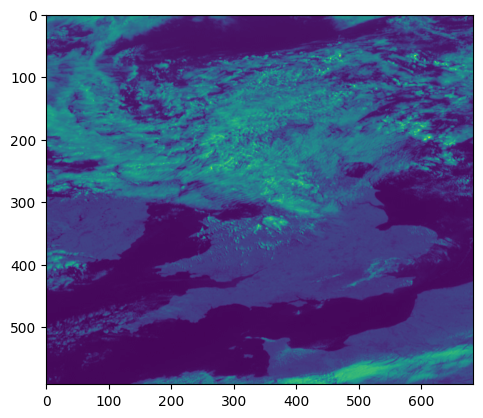

In [4]:
plt.imshow(hrv["data"].sel(time="2020-07-20 08:00").to_numpy()[::-1])

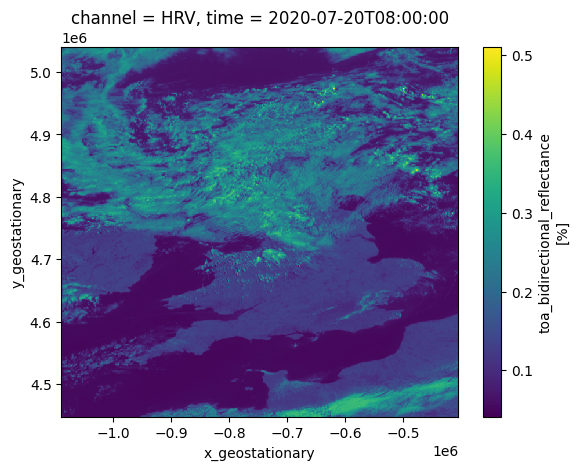

In [5]:
hrv["data"].sel(time="2020-07-20 08:00").plot()  # type: ignore

A slightly more advanced version of this allows us to draw coastlines on top of the data.

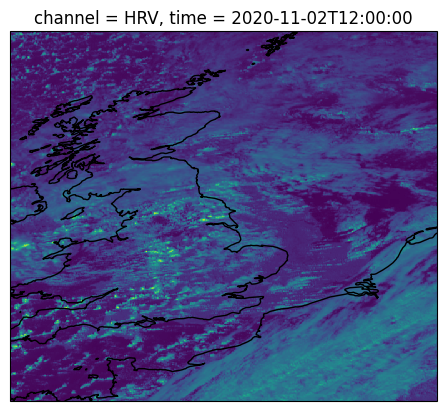

In [26]:
axes = plt.axes(projection=ccrs.Geostationary(central_longitude=12))

hrv = xr.open_dataset(
    "/data/climatehack/official_dataset/hrv/2020/11.zarr.zip",
    engine="zarr",
    consolidated=True,
)

hrv["data"].sel(time="2020-11-2 12:00", channel="HRV").plot.pcolormesh(
    ax=axes,
    transform=ccrs.Geostationary(central_longitude=12),
    x="x_geostationary",
    y="y_geostationary",
    add_colorbar=False,
)  # type: ignore

axes.coastlines()

## Non-HRV Satellite Imagery

We can also perform something similar for the non-HRV satellite imagery data.

In [7]:
nonhrv = xr.open_dataset(
    "/data/climatehack/official_dataset/nonhrv/2020/7.zarr.zip",
    engine="zarr",
    consolidated=True,
)

nonhrv

<xarray.Dataset>
Dimensions:          (channel: 11, time: 6721, y_geostationary: 293,
                      x_geostationary: 333)
Coordinates:
  * channel          (channel) <U6 'IR_016' 'IR_039' ... 'WV_062' 'WV_073'
  * time             (time) datetime64[ns] 2020-07-01T04:00:00 ... 2020-07-31...
  * x_geostationary  (x_geostationary) float64 -2.52e+05 ... -1.248e+06
  * y_geostationary  (y_geostationary) float64 4.303e+06 4.306e+06 ... 5.179e+06
Data variables:
    data             (time, y_geostationary, x_geostationary, channel) float16 ...

Notice how the non-HRV satellite imagery data is composed of 11 different channels:

In [8]:
nonhrv.channel

<xarray.DataArray 'channel' (channel: 11)>
array(['IR_016', 'IR_039', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134',
       'VIS006', 'VIS008', 'WV_062', 'WV_073'], dtype='<U6')
Coordinates:
  * channel  (channel) <U6 'IR_016' 'IR_039' 'IR_087' ... 'WV_062' 'WV_073'

We can select one of these channels (in this case, an infrared one) and plot it in a similar way to the previous example involving HRV data.

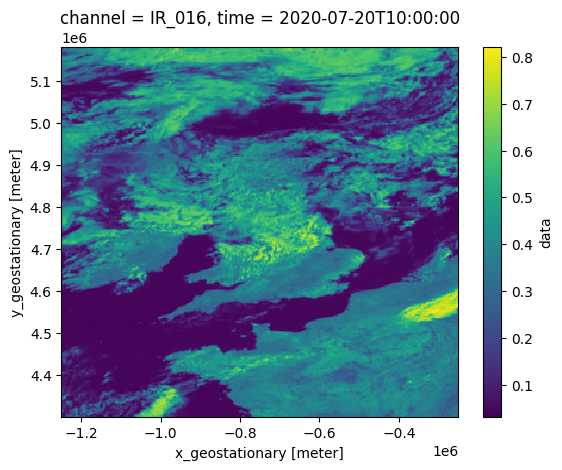

In [9]:
nonhrv["data"].sel(time="2020-07-20 10:00", channel="IR_016").plot()  # type: ignore

## Weather Forecasts

We can also look at the weather forecast dataset by loading and visualising it in a very similar way!

As you can see, this dataset is composed of 38 different data variables (many of which correspond to different altitudes), such as for ground temperatures, total precipitation and more. For further information on each of these data variables, check out the data section on the [ClimateHack.AI 2023 competition page](https://doxaai.com/competition/climatehackai-2023/overview).

In [10]:
nwp = xr.open_dataset(
    "/data/climatehack/official_dataset/weather/2020/7.zarr.zip",
    engine="zarr",
    consolidated=True,
)

nwp

<xarray.Dataset>
Dimensions:     (time: 513, latitude: 305, longitude: 289)
Coordinates:
  * latitude    (latitude) float64 45.0 45.06 45.12 45.19 ... 63.88 63.94 64.0
  * longitude   (longitude) float64 -11.0 -10.94 -10.88 ... 6.875 6.938 7.0
  * time        (time) datetime64[ns] 2020-07-01T04:00:00 ... 2020-07-31T22:0...
Data variables: (12/38)
    alb_rad     (time, latitude, longitude) float32 ...
    aswdifd_s   (time, latitude, longitude) float32 ...
    aswdir_s    (time, latitude, longitude) float32 ...
    cape_con    (time, latitude, longitude) float32 ...
    clch        (time, latitude, longitude) float32 ...
    clcl        (time, latitude, longitude) float32 ...
    ...          ...
    v_850       (time, latitude, longitude) float32 ...
    v_950       (time, latitude, longitude) float32 ...
    vmax_10m    (time, latitude, longitude) float32 ...
    w_snow      (time, latitude, longitude) float32 ...
    ww          (time, latitude, longitude) float32 ...
    z0          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_edition:            2
    GRIB_subCentre:          255
    history:                 2023-10-14T03:40 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             Offenbach

### Ground temperatures

Just as with the satellite imagery data, we can also plot individual data variables in the weather forecast dataset. Here, `t_g` corresponds to ground-level temperatures in Kelvin (which we convert to Celsius in the visualisation below).

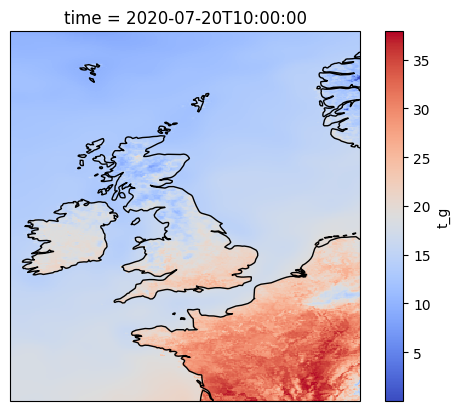

In [11]:
axes = plt.axes(projection=ccrs.PlateCarree())

(nwp["t_g"].sel(time="2020-07-20 10:00") - 273.15).plot.pcolormesh(
    ax=axes,
    transform=ccrs.PlateCarree(),
    x="longitude",
    y="latitude",
    add_colorbar=True,
    cmap="coolwarm",
)  # type: ignore

axes.coastlines()

### Cloud cover

Similarly, we can also look at total cloud cover forecasts (`clct`).

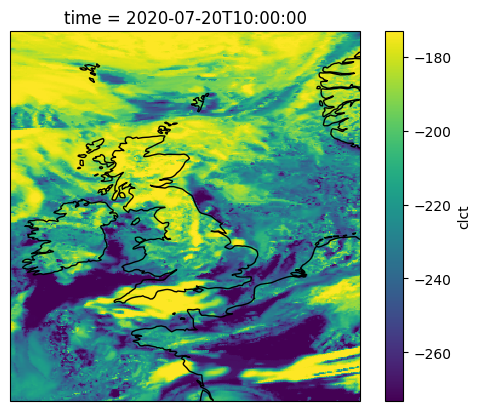

In [12]:
axes = plt.axes(projection=ccrs.PlateCarree())

(nwp["clct"].sel(time="2020-07-20 10:00") - 273.15).plot.pcolormesh(
    ax=axes,
    transform=ccrs.PlateCarree(),
    x="longitude",
    y="latitude",
    add_colorbar=True,
)  # type: ignore

axes.coastlines()

## All weather variables

Here are all the weather variables available in this dataset.

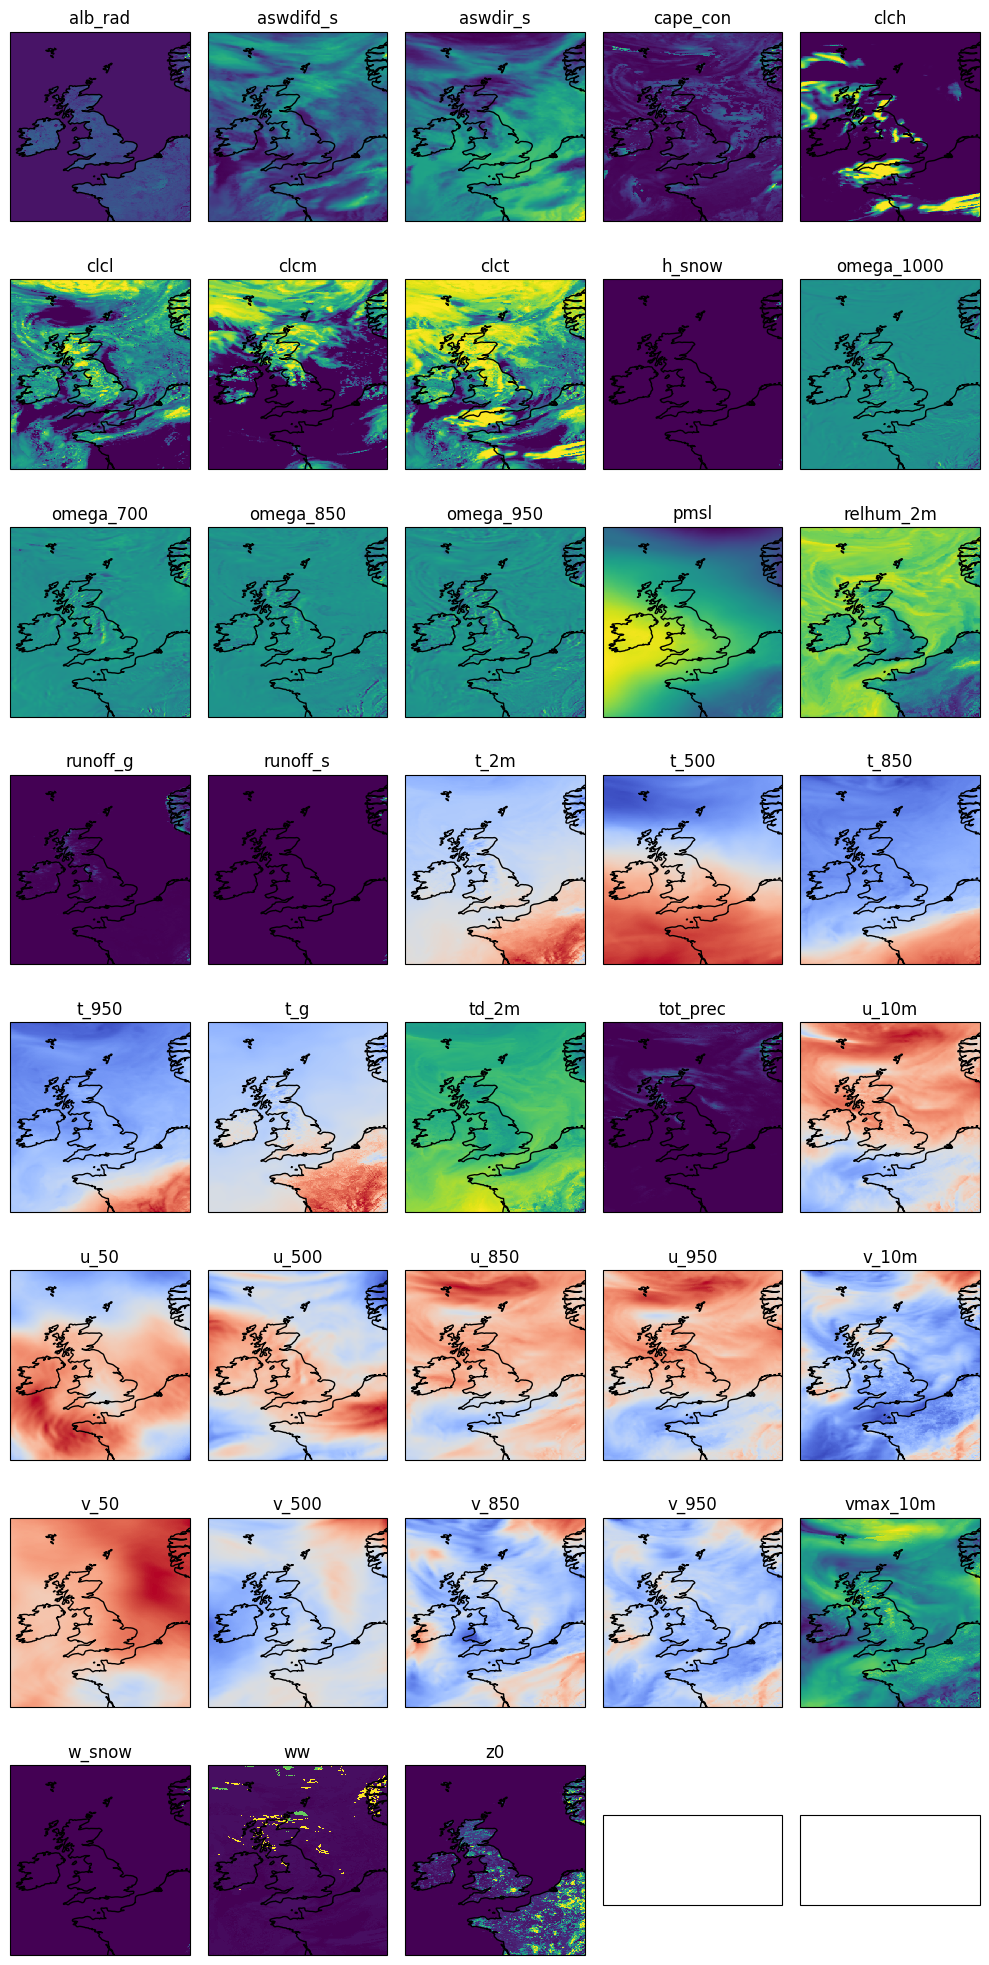

In [13]:
nrows = 8
ncols = 5

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(10, 20),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

for i, var in enumerate(nwp.data_vars):
    nwp[var].sel(time="2020-07-20 10:00",).plot.pcolormesh(
        ax=axes[i // ncols][i % ncols],
        transform=ccrs.PlateCarree(),
        x="longitude",
        y="latitude",
        add_colorbar=False,
        cmap="coolwarm" if var.split("_")[0] in ("t", "v", "u") else "viridis",
    )

    axes[i // ncols][i % ncols].coastlines()
    axes[i // ncols][i % ncols].get_xaxis().set_visible(False)
    axes[i // ncols][i % ncols].get_yaxis().set_visible(False)
    axes[i // ncols][i % ncols].set_title(var)

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)

## Air Quality Forecasts

Finally, we can also explore the ECMWF CAMS air quality forecast dataset, which contains a number of data variables related to aerosols in the atmosphere at 8 different levels. There is a lot of aerosol data available, so if you are interested in using the aerosol data as part of your submission, it is worth spending some time to get familiar with the data and figure out which data variables are actually useful to you. For example, not all aerosol types are found in large concentrations over Great Britain, which is our area of interest. 

In [14]:
aerosols = xr.open_dataset(
    "/data/climatehack/official_dataset/aerosols/2020/7.zarr.zip",
    engine="zarr",
    consolidated=True,
)

aerosols

<xarray.Dataset>
Dimensions:     (time: 589, level: 8, latitude: 250, longitude: 240)
Coordinates:
  * latitude    (latitude) float32 66.95 66.85 66.75 66.65 ... 42.25 42.15 42.05
  * level       (level) float64 0.0 50.0 250.0 500.0 1e+03 2e+03 3e+03 5e+03
  * longitude   (longitude) float32 -13.95 -13.85 -13.75 ... 9.75 9.85 9.95
  * time        (time) datetime64[ns] 2020-07-01T04:00:00 ... 2020-07-31T22:0...
Data variables: (12/13)
    co_conc     (time, level, latitude, longitude) float32 ...
    dust        (time, level, latitude, longitude) float32 ...
    nh3_conc    (time, level, latitude, longitude) float32 ...
    nmvoc_conc  (time, level, latitude, longitude) float32 ...
    no2_conc    (time, level, latitude, longitude) float32 ...
    no_conc     (time, level, latitude, longitude) float32 ...
    ...          ...
    pans_conc   (time, level, latitude, longitude) float32 ...
    pm10_conc   (time, level, latitude, longitude) float32 ...
    pm2p5_conc  (time, level, latitude, longitude) float32 ...
    pmwf_conc   (time, level, latitude, longitude) float32 ...
    sia_conc    (time, level, latitude, longitude) float32 ...
    so2_conc    (time, level, latitude, longitude) float32 ...
Attributes:
    FORECAST:     Europe, 20200301+[0H_48H]
    history:      Model ENSEMBLE FORECAST
    institution:  Data produced by Meteo France
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    source:       Data from ENSEMBLE model
    summary:      ENSEMBLE model hourly FORECAST of CO/Dust/NH3/NMVOC/NO2/NO/...
    title:        CO/Dust/NH3/NMVOC/NO2/NO/O3/PANS/PM10/PM25/PM_Wildfire/SIA/...

In [15]:
aerosols.level

<xarray.DataArray 'level' (level: 8)>
array([   0.,   50.,  250.,  500., 1000., 2000., 3000., 5000.])
Coordinates:
  * level    (level) float64 0.0 50.0 250.0 500.0 1e+03 2e+03 3e+03 5e+03
Attributes:
    long_name:  level
    units:      m

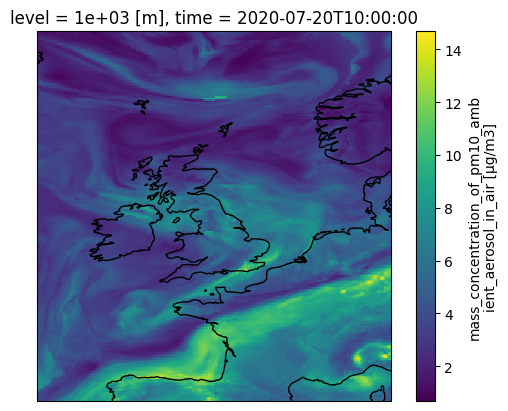

In [16]:
axes = plt.axes(projection=ccrs.PlateCarree())

aerosols["pm10_conc"].sel(time="2020-07-20 10:00", level=1000).plot.pcolormesh(
    ax=axes,
    transform=ccrs.PlateCarree(),
    x="longitude",
    y="latitude",
    add_colorbar=True,
)  # type: ignore

axes.coastlines()

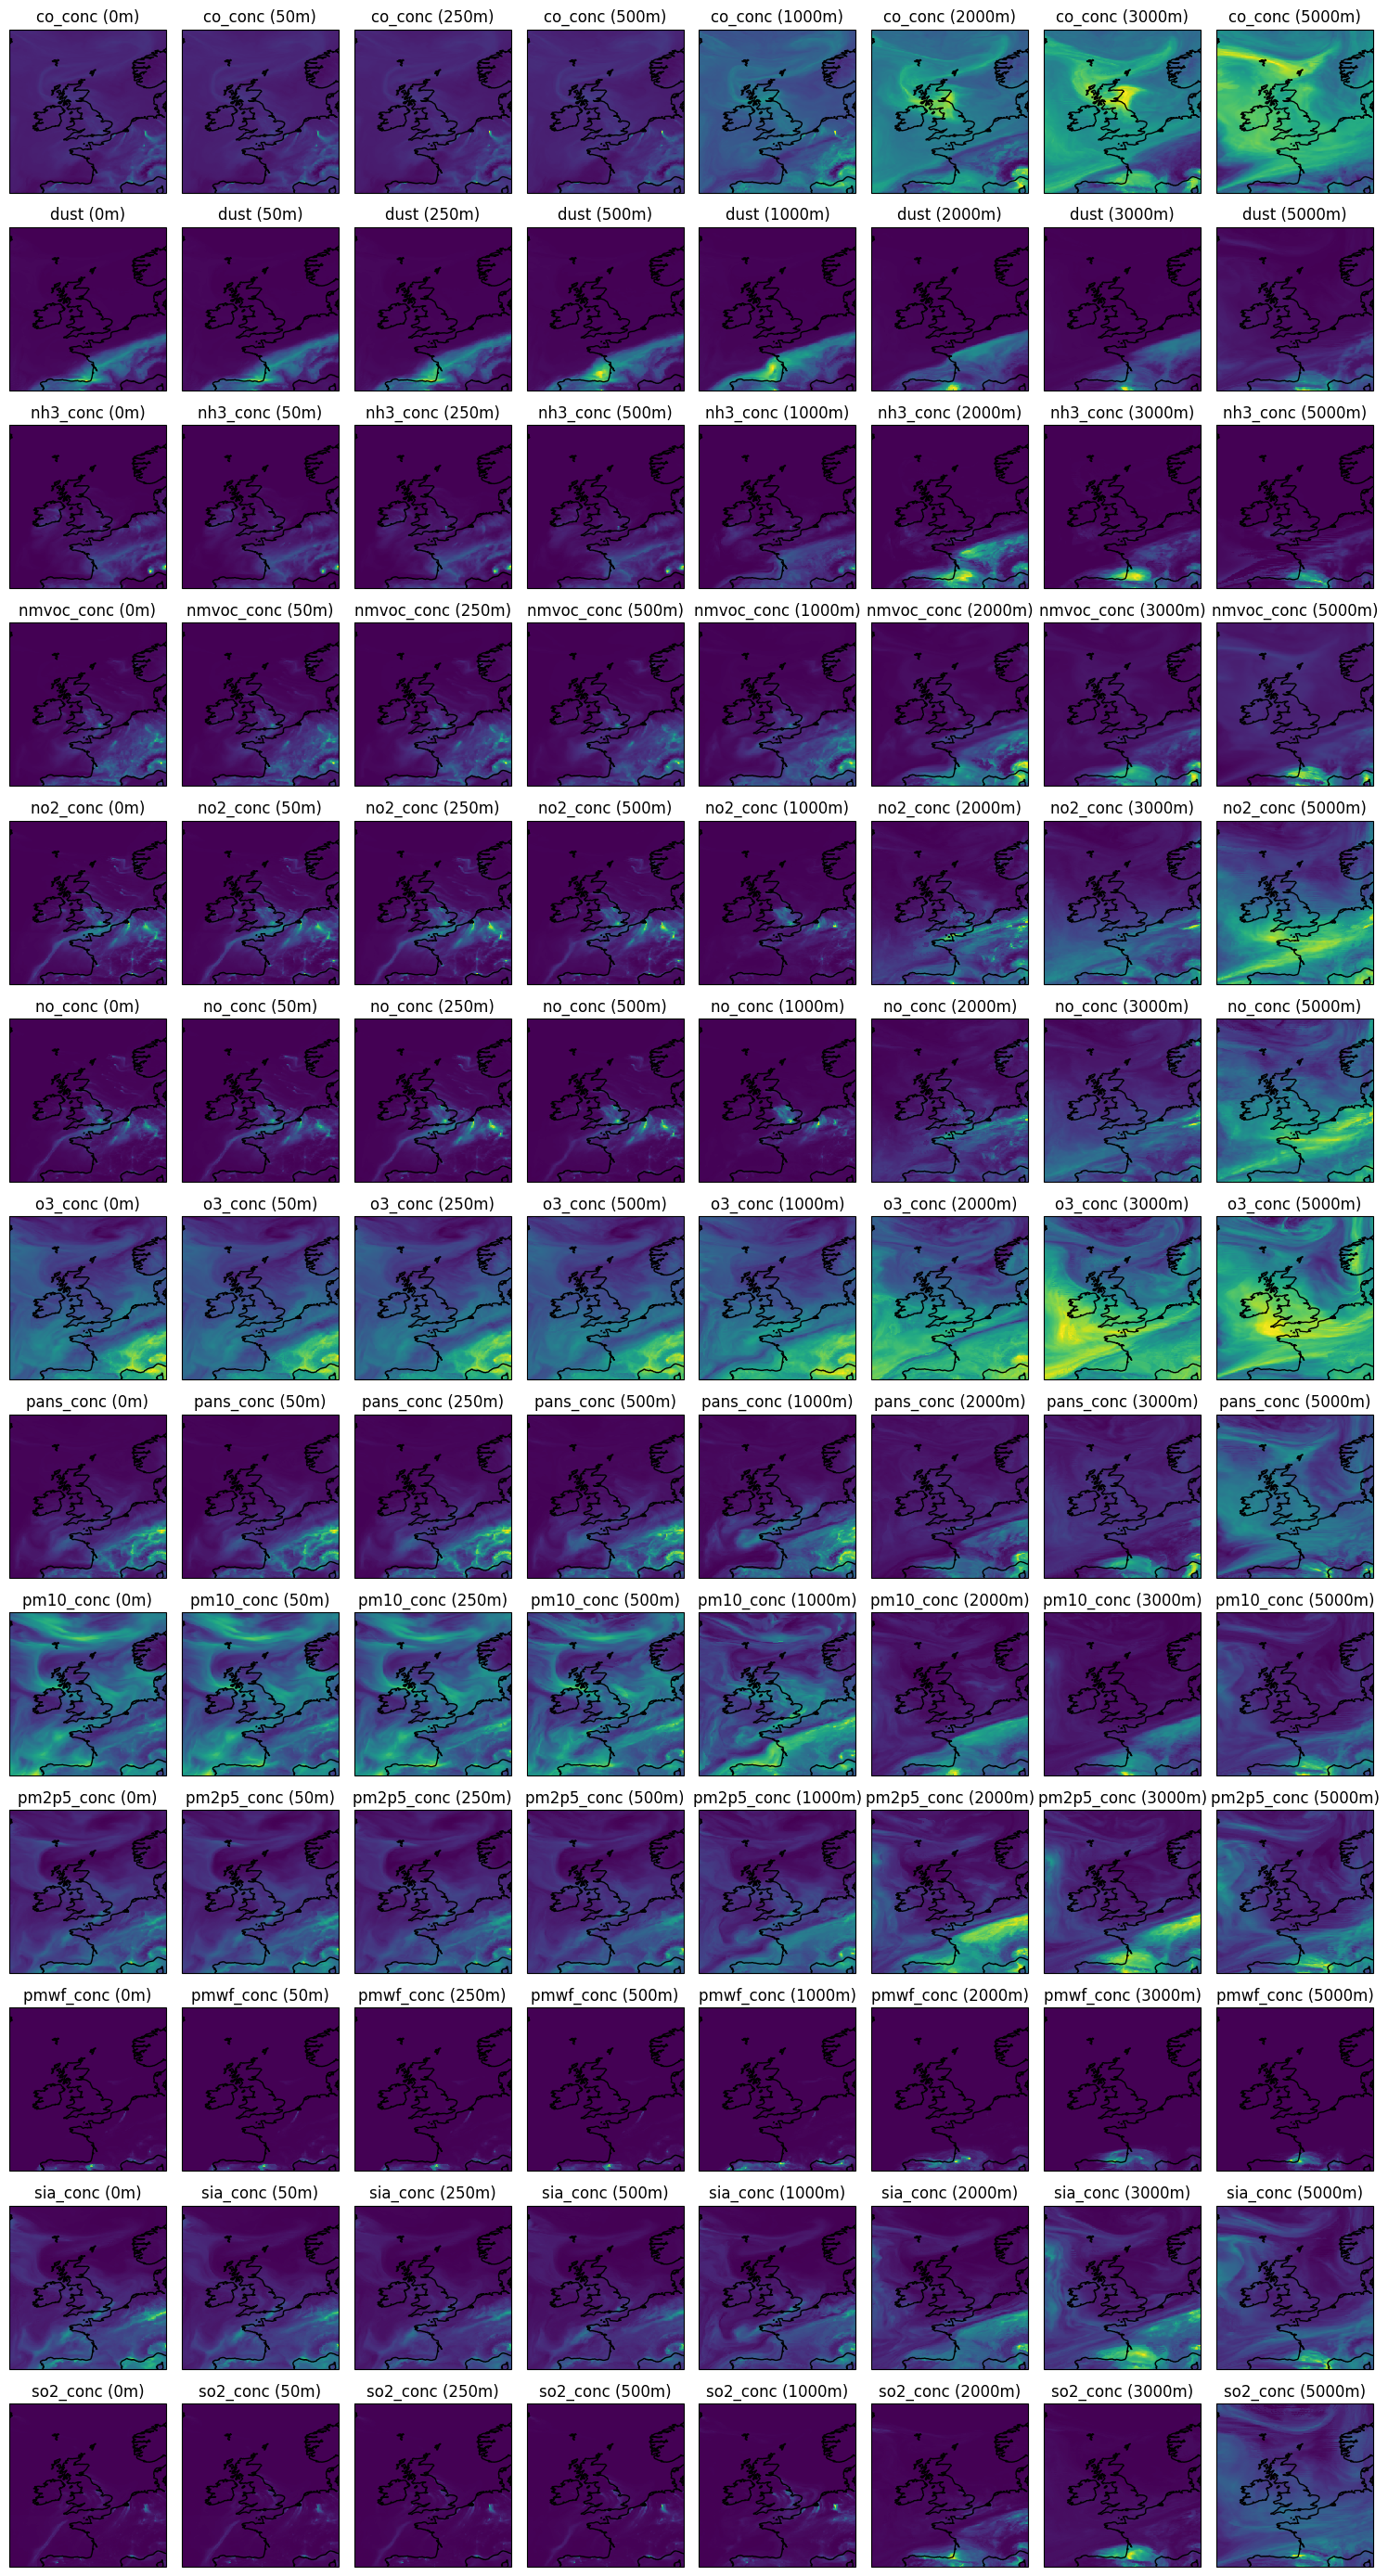

In [17]:
fig, axes = plt.subplots(
    nrows=len(aerosols.data_vars),
    ncols=len(aerosols.level),
    figsize=(15, 28),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

for i, var in enumerate(aerosols.data_vars):
    for j, level in enumerate(aerosols.level):
        aerosols[var].sel(time="2020-07-20 10:00", level=level).plot.pcolormesh(
            ax=axes[i][j],
            transform=ccrs.PlateCarree(),
            x="longitude",
            y="latitude",
            add_colorbar=False,
            cmap="viridis",
        )

        axes[i][j].coastlines()
        axes[i][j].get_xaxis().set_visible(False)
        axes[i][j].get_yaxis().set_visible(False)
        axes[i][j].set_title(f"{var} ({int(level)}m)")

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)

## PV Data

In [18]:
from pathlib import Path
data_dir = Path('/data/climatehack/official_dataset/pv/2020/')
# pv = pd.concat(
#     pd.read_parquet(parquet_file).drop("generation_wh", axis=1)
#     for parquet_file in data_dir.glob('*.parquet')
# )
pv = pd.read_parquet('/data/climatehack/official_dataset/pv/2020/7.parquet')

In [19]:
pv.loc[('2020-07-01 00:00:00+00:00',  2766)]

generation_wh    0.0
power            0.0
Name: (2020-07-01 00:00:00+00:00, 2766), dtype: float64

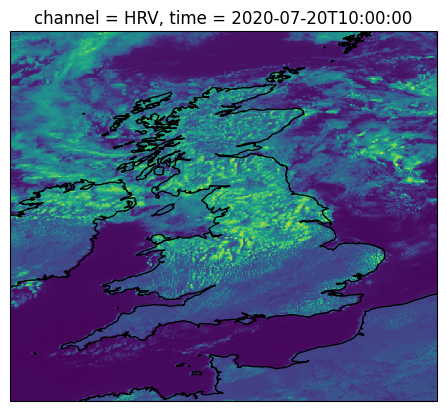

In [20]:
axes = plt.axes(projection=ccrs.Geostationary(central_longitude=9.5))

hrv["data"].sel(time="2020-07-20 10:00", channel="HRV").plot.pcolormesh(
    ax=axes,
    transform=ccrs.Geostationary(central_longitude=9.5),
    x="x_geostationary",
    y="y_geostationary",
    add_colorbar=False,
)  # type: ignored

axes.coastlines()